# Photosynthestic measurement statistical testing

We want to perform a statistical test to see if the phi2 and NPQ curves for the various conditions are significantly different from one another. To do this, we'll use pandas to implement [this spreadhseet method](https://pmc.ncbi.nlm.nih.gov/articles/PMC10617697/) for determining whether two arbitrary curves are significantly different.

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm
from math import sqrt
from scipy.stats import t
from scipy.stats.distributions import chi2
import matplotlib.pyplot as plt

## Read in data
Our own data:

In [2]:
curves = pd.read_csv('../data/7h_acclimation.csv')
print(curves.shape)
curves.head()

(636, 4)


,Oxygen,Time,NPQ,Phi2
0,2,0.0000,0.4951,0.1662
1,2,0.0342,0.8324,0.2652
2,2,0.0667,0.9611,0.2952
3,2,0.1000,1.0663,0.3038
4,2,0.1333,1.1211,0.3128


Check how many samples we have for each time point at each condition:

In [3]:
check_cols = curves.groupby(by=['Oxygen', 'Time']).count().to_numpy()
print(f'Do we have the same number of samples across all timepoints and conditions? {(check_cols[0] == check_cols).all(0)}')
print(f'There are {check_cols[0][0]} samples for phi2 and {check_cols[0][1]} samples for NPQ at each condition.')
N = check_cols[0][0]

Do we have the same number of samples across all timepoints and conditions? [ True  True]
There are 4 samples for phi2 and 4 samples for NPQ at each condition.


Plot to visualize:

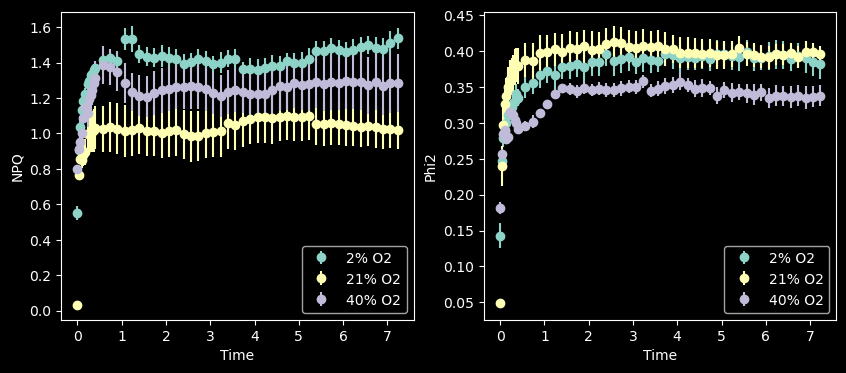

In [17]:
curves_grouped = curves.groupby(['Time', 'Oxygen']).agg(['mean', 'std']).reset_index()
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 2, figsize=(10,4), facecolor=None)

for y, ax in zip(['NPQ', 'Phi2'], axs):

    for cond in [2, 21, 40]:

        to_plot = curves_grouped[curves_grouped['Oxygen'] == cond]
        ax.errorbar(to_plot['Time'], to_plot[y, 'mean'], yerr=to_plot[y, 'std'], fmt='o', label=f'{cond}% O2')
        ax.set_xlabel('Time')
        ax.set_ylabel(y)
        ax.legend()
plt.savefig('../data/npq_phi2_plot.png', transparent=True, dpi=600, format='png')

In addition to our own data, we also want to read in the sample data from the paper so we can test our implementation.

In [5]:
sample_data = pd.read_csv('../data/hristova_and_whitley_sample_data.csv', header=[0,1], index_col=0)
sample_data.head()

CURVE_1                          CURVE_2                        
X-value     mean       sd count      sem     mean       sd count      sem
0        0.51504  0.12241     3  0.12241  1.16572  0.22652     3  0.22652
5        0.30914  0.08946     3  0.08946  0.82235  0.17158     3  0.17158
25       0.14943  0.06391     3  0.06391  0.70776  0.15324     3  0.15324
50       0.20525  0.07284     3  0.07284  0.67317  0.14771     3  0.14771
125      0.15132  0.06421     3  0.06421  0.38958  0.10233     3  0.10233

Visualize the sample data:

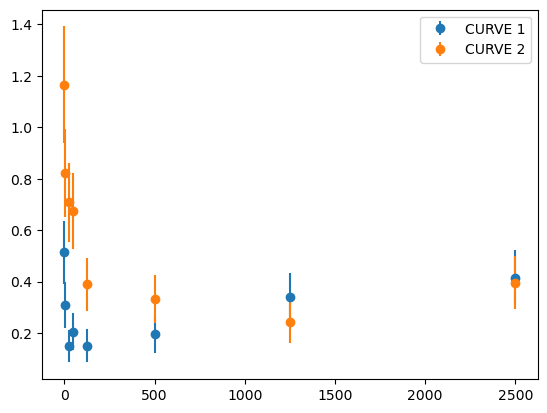

In [6]:
plt.errorbar(sample_data.index, sample_data['CURVE_1', 'mean'], yerr=sample_data['CURVE_1', 'sd'], fmt='o', label='CURVE 1')
plt.errorbar(sample_data.index, sample_data['CURVE_2', 'mean'], yerr=sample_data['CURVE_2', 'sd'], fmt='o', label='CURVE 2')
plt.legend()

## Implementing the method
Here I'll explain how I interpreted the spreadsheet method and implemented it here. There are a set of intermediate calculations in the spreadsheet, the results of which look like this:

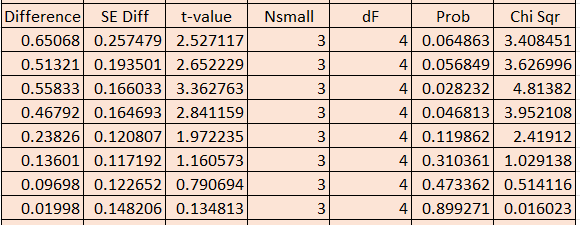

Going into the formulas in the cells, the definition of each of these columns is:
* Difference: $|mean_{curve2} - mean_{curve1}|$
* SE Diff: $\sqrt{SE_{curve1}^{2} + SE_{curve2}^{2}}$
* t-value: $Difference/SE diff$
* Nsmall: $min(N_{curve1}, N_{curve2})$
* dF: $2*Nsmall-2$
* Prob: Result of a t-test on the t-value
* Chi Sqr: [inverse of the right-tailed probability of the chi-squared distribution](https://support.microsoft.com/en-us/office/chisq-inv-rt-function-435b5ed8-98d5-4da6-823f-293e2cbc94fe)
* Sum Chi Sqr: Sum of all the Chi Sqr values for all points
* dF for Chi Sqr: the number of x-values
* P VALUE: The overall p-value, calculated as 1 - the chi2 distribution

**Implementation note:** I couldn't find a direct answer on what the Python equivalent of the Excel `T.DIST.2T` function is, but the Google AI box says the following:

The equivalent of Excel's T.DIST.2T function in Python is found within the scipy.stats module as t.cdf. T.DIST.2T calculates the two-tailed t-distribution for a given value, degrees of freedom, and considers both tails of the distribution. The t.cdf function calculates the cumulative distribution function, and to replicate T.DIST.2T, it must be manipulated to account for both tails. 

Here's how to achieve the equivalent functionality: 
```
from scipy.stats import t

def t_dist_2t(x, degrees_freedom):
  """
  Calculates the two-tailed t-distribution probability, equivalent to Excel's T.DIST.2T.

  Args:
    x: The value at which to evaluate the t-distribution.
    degrees_freedom: The degrees of freedom.

  Returns:
    The two-tailed t-distribution probability.
  """
  return 2 * (1 - t.cdf(abs(x), degrees_freedom))

# Example usage:
x_value = 2.5
df = 20
probability = t_dist_2t(x_value, df)
print(probability)
```

In [7]:
def calculate_pval(comp_df):
    """
    Helper for twoCurveTest that does the statistical heavy lifting.
    """
    # Add columns for intermediate calculation values
    comp_headers = list(set(comp_df.columns.get_level_values(0)))
    comp_df['int_calc', 'difference'] = abs(comp_df[comp_headers[0], 'mean'] - comp_df[comp_headers[1], 'mean'])
    comp_df['int_calc', 'se_difference'] = (comp_df[comp_headers[0], 'sem']**2 + comp_df[comp_headers[1], 'sem']**2).apply(sqrt)
    comp_df['int_calc', 't_value'] = comp_df['int_calc', 'difference']/comp_df['int_calc', 'se_difference']
    comp_df['int_calc', 'nSmall'] = comp_df[[(comp_headers[0], 'count'), (comp_headers[1], 'count')]].min(axis=1)
    comp_df['int_calc', 'dF'] = 2*comp_df['int_calc', 'nSmall'] - 2
    comp_df['int_calc', 'prob'] = 2 * (1 - t.cdf(abs(comp_df['int_calc', 't_value']), comp_df['int_calc', 'dF'])) ## I am trusting the Google AI box on this one
    comp_df['int_calc', 'chi2'] = chi2.ppf(1 - comp_df['int_calc', 'prob'], 1)

    # Do the overall calculation
    sum_chi2 = comp_df['int_calc', 'chi2'].sum()
    chi2_df = len(comp_df)
    pval = 1 - chi2.cdf(sum_chi2, chi2_df)

    return pval

def twoCurveTest(curves, x, measurement, condition):
    """
    Test whether two arbitrary curves are significantly different from one
    another using the method described in:

    Hristova, Kalina, and William C. Wimley. "Determining the statistical
    significance of the difference between arbitrary curves: A spreadsheet
    method." Plos one 18.10 (2023): e0289619.
    https://pmc.ncbi.nlm.nih.gov/articles/PMC10617697/

    Applies a multiple test correction if comparing multiple curves.

    parameters:
        curves, df: minimally has columns for one x value and one y value
        x, str: name of the df column specifying the x variable
        measurement, str: column name for y-values
        condition, str: name of the column specifying a condition for which
            curves should be compared

    returns:
        pvals, dict: keys are condition comparisons, values are p-values
    """
    # Split up the conditions to be compared
    all_conditions = set(curves[condition].tolist())
    cols_to_skip = [col for col in curves.columns if col not in [measurement, x]]
    condition_dfs = {
        cond: curves[curves[condition] == cond].drop(columns=cols_to_skip)
        for cond in all_conditions
    }

    pvals = {}
    for cond_pair in tqdm(combinations(all_conditions, 2)):

        # Get summary stats for each condition
        cond1_df = condition_dfs[cond_pair[0]]
        cond2_df = condition_dfs[cond_pair[1]]
        cond1_stats = cond1_df.groupby(x).agg(
            ['count', 'mean', 'std', 'sem'])
        cond2_stats = cond2_df.groupby(x).agg(
            ['count', 'mean', 'std', 'sem'])
    
        # Merge the two conditions together
        comp_df = pd.merge(cond1_stats, cond2_stats, left_on=x, right_on=x,
                           suffixes=(f'_{cond_pair[0]}', f'_{cond_pair[1]}'))

        pvals[cond_pair] = calculate_pval(comp_df)

    # Apply multiple testing correction
    pvals = {k: v/len(pvals) for k, v in pvals.items()}

    return pvals

## Check implementation
We've read in the sample data from the paper, what we want to see as a result is a p-value of 1.12E-02:

In [8]:
calculate_pval(sample_data)

np.float64(0.011202147116258776)

That's what we want to see! Our intermediate calculations all also have the same values (removed the print statement for visual simplicity).

## Perform calculation on real data
Now that we've showed we can get the same result as the spreadsheet implementation, we can apply it to our own data:

In [9]:
pvals_NPQ = twoCurveTest(curves, x='Time', measurement='NPQ', condition='Oxygen')
pvals_phi2 = twoCurveTest(curves, x='Time', measurement='Phi2', condition='Oxygen')

3it [00:00, 81.09it/s]
3it [00:00, 85.99it/s]


In [10]:
pvals_phi2

{(40, 2): np.float64(0.0),
 (40, 21): np.float64(0.0),
 (2, 21): np.float64(5.24476128560547e-06)}

In [11]:
pvals_NPQ

{(40, 2): np.float64(0.0), (40, 21): np.float64(0.0), (2, 21): np.float64(0.0)}

These p-values demonstrate that the curves are significantly differently shaped/valued from one another. However, our belief about these curves is that for Phi2, the 2% curve is not significantly different from the 21% curve after 4 hours of measurement -- that it acclimates and returns to ambient levels. Let's try testing this by splitting the curves at 5 hours:

In [18]:
pre5 = curves[curves['Time'] < 3.5]
post5 = curves[curves['Time'] >= 3.5]

In [19]:
pvals_phi2_pre5 = twoCurveTest(pre5, x='Time', measurement='Phi2', condition='Oxygen')
pvals_phi2_post5 = twoCurveTest(post5, x='Time', measurement='Phi2', condition='Oxygen')

3it [00:00, 75.76it/s]
3it [00:00, 85.33it/s]


In [20]:
pvals_phi2_pre5, pvals_phi2_post5

({(40, 2): np.float64(0.0),
  (40, 21): np.float64(0.0),
  (2, 21): np.float64(7.475260780746377e-10)},
 {(40, 2): np.float64(0.0),
  (40, 21): np.float64(0.0),
  (2, 21): np.float64(0.3329577867527292)})

It looks like the 2% oxygen condition does in fact return to ambient levels!